# LightGCNPlus

### TODO: 
- try to not standardize the ratings

### Scope
In this notebook we train different variants of our LightGCNPlus model on different hyperparameters. We then re-train the best performing model and evaluate it on Kaggle's public test set.

### About the model
LightGCNPlus is a graph-based collaborative filtering model that extends the [original LightGCN model](https://arxiv.org/pdf/2002.02126.pdf). The original LightGCN is only able to rank items. We thus refine the model to be able to predict ratings. Our LightGCNPlus model is composed of the following components:
- message passing: $e_u^{(l)} = \sum_{v \in N(u)} \frac{sr_{u,v}}{\sqrt{|N(u)||N(v)|}} e_v^{(l-1)}$, where $sr_{u,v}$ is the standardized rating of user $u$ for item $v$.
- aggregation mechanism: $h_u = \text{concat}(e_u^{(0)}, e_u^{(1)}, ..., e_u^{(L)})$, where $L$ is the number of layers in the message passing mechanism.
- output layer: $\hat{R}_{(i,j)} = \text{MLP}(\text{concat}(h_i, h_j))$, where $\text{MLP}$ is a multi-layer perceptron that projects the embedding couples of observed ratings to the output space.

How our model differs from the original LightGCN:
- In the message passing layer we use the standardized ratings instead of the raw interactions (binary in the original case).
- We use an MLP in the output layer instead of a dot product. This inspired by the [neural collaborative filtering paper](https://arxiv.org/pdf/1708.05031.pdf), in order to predict ratings instead of just ranking unobserved interactions.

### Hyperparameter tuning
The hyperparameters comprise both choices about the models' architecture and the training procedure.
We perform a grid search over the following hyperparameters:
- K: Embedding size.
- L: Number of layers in the message passing mechanism.
- PROJECTIONS: Architecture of the MLP that projects the embedding couples of observed ratings to the output space.

Other hyperparameters such as the learning rate, the batch size, the number of epochs, the optimizer, etc. have been selected based on the results on previous experiments. Thus, to reduce the computational cost of the grid search, the following hyperparameters are kept constant:
- LR: learning rate.
- INIT_EMBS_STD: standard deviation of the normal distribution used to initialize the embeddings.
- WEIGHT_DECAY: weight decay coefficient for the Adam optimizer.
- DROPOUT: dropout rate used in the MLP's hidden layers.
- ACT_FN: activation function used in the MLP's hidden layers.

We also define hyperparameters for the training procedure:
- EPOCHS: number of backpropagation steps.
- STOP_THRESHOLD: minimum improvement in the validation loss to continue training.

### Training
- loss functions:
    - train: $\text{MSE} = \frac{1}{|\Omega|} \sum_{(i,j) \in \Omega} (M_{(i,j)} - \hat{M}_{(i,j)})^2$
    - eval: $\text{RMSE} = \sqrt{\text{MSE}}$
- optimizer: Adam
- Batching: no mini-batching of the training data, doesn't improve performance and slows convergence down. 
- Regularization: dropout and L2 regularization (weight decay in the Adam optimizer).

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from train import train_model
from models import LightGCNPlus
from config import DEVICE
from train import train_model
from postprocess import report_training_results
from itertools import product

## 1. Load and Preprocessing

In [2]:
from load import load_train_data
train_df = load_train_data()

In [3]:
from preprocess import preprocess

A_tilde, \
standardized_train_ratings, \
train_users, train_items, \
means, stds, \
val_users, \
val_items, \
orig_val_ratings, \
standardized_val_ratings \
= preprocess(train_df)

## 2. Train and Report

In the ideal case one would search over multiple splits of the train and val sets.

In [4]:
# Model and optimizer hyperparameters
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5
ACT_FN = nn.GELU()

# Train loop hyperparameters
EPOCHS = 4000
STOP_THRESHOLD=1e-09

# To be searched (example values)
# K=28
# L=4
# PROJECTIONS = (4,)

In [5]:
# Grid
ks = [28, 30, 32]  # different Ks work with different projections
layers = [4, 5]  # tested 3 already
projections = [(6,1), (6,), (5, 1), (5,), (4, 1), (4,), (3, 1), (3,), (2, 1), (2,)]

num_combinations = len(ks) * len(layers) * len(projections)
print(f"Searching over {num_combinations} combinations.")

Searching over 60 combinations.


K=28, L=4, C=(6, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 1.0196 - Val std: 1.0110 - Val orig: 1.0431
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9701 - Val std: 0.9706 - Val orig: 1.0029
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9539 - Val std: 0.9587 - Val orig: 0.9912
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9480 - Val std: 0.9546 - Val orig: 0.9870
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9458 - Val std: 0.9536 - Val orig: 0.9861
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9419 - Val std: 0.9534 - Val orig: 0.9857
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9401 - Val std: 0.9535 - Val orig: 0.9859
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9393 - Val std: 0.9541 - Val orig: 0.9866
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9389 - Val std: 0.9545 - Val orig: 0.9870
Best val loss: 0.9835 at epoch 2013


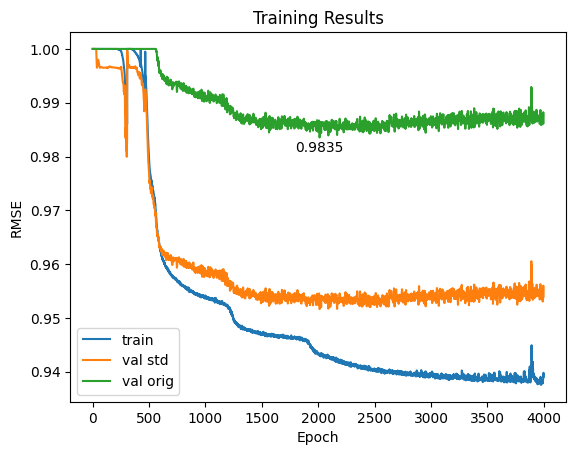

K=28, L=4, C=(6,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 1.0100 - Val std: 1.0078 - Val orig: 1.0409
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9539 - Val std: 0.9595 - Val orig: 0.9919
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9475 - Val std: 0.9556 - Val orig: 0.9879
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9428 - Val std: 0.9548 - Val orig: 0.9871
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9412 - Val std: 0.9563 - Val orig: 0.9885
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9409 - Val std: 0.9565 - Val orig: 0.9887
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9408 - Val std: 0.9567 - Val orig: 0.9890
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9401 - Val std: 0.9568 - Val orig: 0.9891
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9390 - Val std: 0.9570 - Val orig: 0.9894
Best val loss: 0.9852 at epoch 1154


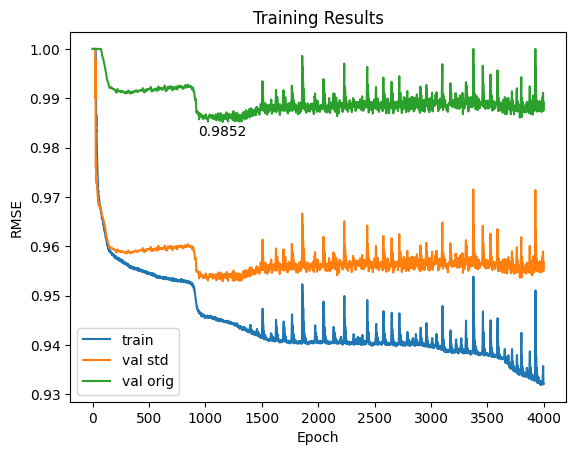

K=28, L=4, C=(5, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9860 - Val std: 0.9810 - Val orig: 1.0135
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9551 - Val std: 0.9607 - Val orig: 0.9935
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9477 - Val std: 0.9583 - Val orig: 0.9910
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9422 - Val std: 0.9576 - Val orig: 0.9899
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9399 - Val std: 0.9579 - Val orig: 0.9900
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9390 - Val std: 0.9582 - Val orig: 0.9902
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9368 - Val std: 0.9599 - Val orig: 0.9917
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9358 - Val std: 0.9605 - Val orig: 0.9922
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9356 - Val std: 0.9612 - Val orig: 0.9929
Best val loss: 0.9874 at epoch 1308


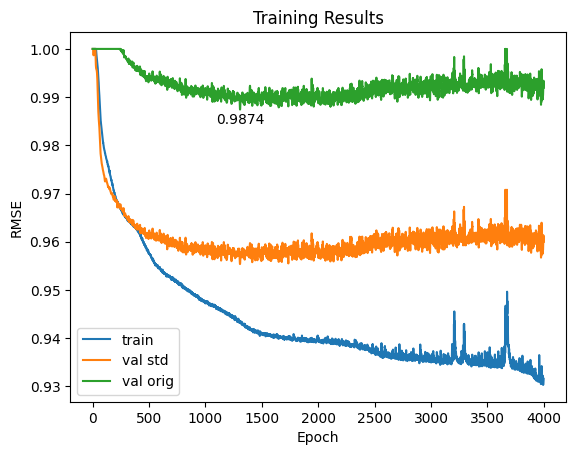

K=28, L=4, C=(5,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 1.0018 - Val std: 1.0024 - Val orig: 1.0351
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9462 - Val std: 0.9562 - Val orig: 0.9886
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9411 - Val std: 0.9532 - Val orig: 0.9855
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9373 - Val std: 0.9534 - Val orig: 0.9857
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9360 - Val std: 0.9549 - Val orig: 0.9874
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9343 - Val std: 0.9554 - Val orig: 0.9880
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9325 - Val std: 0.9563 - Val orig: 0.9887
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9303 - Val std: 0.9555 - Val orig: 0.9879
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9282 - Val std: 0.9555 - Val orig: 0.9878
Best val loss: 0.9839 at epoch 1068


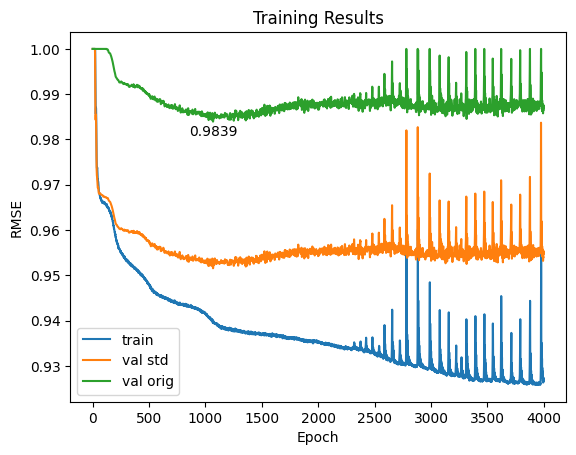

K=28, L=4, C=(4, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9608 - Val std: 0.9628 - Val orig: 0.9952
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9446 - Val std: 0.9562 - Val orig: 0.9883
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9426 - Val std: 0.9566 - Val orig: 0.9887
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9422 - Val std: 0.9569 - Val orig: 0.9890
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9418 - Val std: 0.9567 - Val orig: 0.9888
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9410 - Val std: 0.9567 - Val orig: 0.9889
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9421 - Val std: 0.9570 - Val orig: 0.9892
Epoch 3200 - Avg loss in last 400 epochs: - Train: 1.5876 - Val std: 1.2629 - Val orig: 1.2918
Epoch 3600 - Avg loss in last 400 epochs: - Train: 1.0004 - Val std: 0.9966 - Val orig: 1.0286
Best val loss: 0.9851 at epoch 529


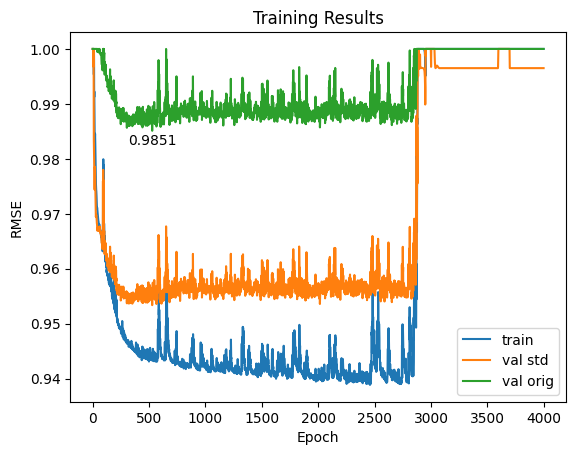

K=28, L=4, C=(4,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9813 - Val std: 0.9846 - Val orig: 1.0173
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9437 - Val std: 0.9543 - Val orig: 0.9867
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9427 - Val std: 0.9534 - Val orig: 0.9858
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9404 - Val std: 0.9537 - Val orig: 0.9862
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9397 - Val std: 0.9548 - Val orig: 0.9874
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9385 - Val std: 0.9550 - Val orig: 0.9876
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9353 - Val std: 0.9546 - Val orig: 0.9871
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9326 - Val std: 0.9547 - Val orig: 0.9871
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9306 - Val std: 0.9558 - Val orig: 0.9882
Best val loss: 0.9839 at epoch 3391


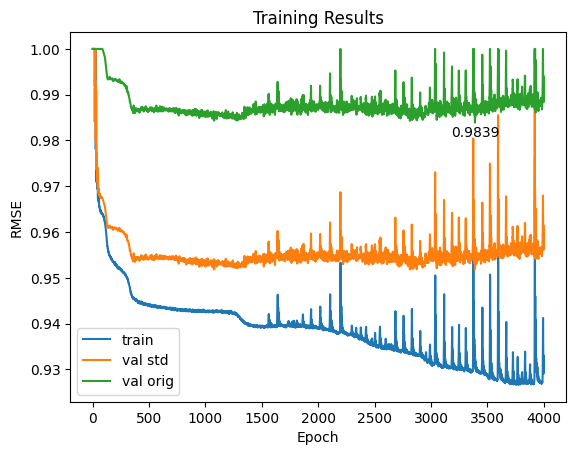

K=28, L=4, C=(3, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9830 - Val std: 0.9773 - Val orig: 1.0100
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9553 - Val std: 0.9599 - Val orig: 0.9922
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9499 - Val std: 0.9567 - Val orig: 0.9889
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9463 - Val std: 0.9554 - Val orig: 0.9875
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9418 - Val std: 0.9549 - Val orig: 0.9870
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9398 - Val std: 0.9542 - Val orig: 0.9865
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9394 - Val std: 0.9541 - Val orig: 0.9864
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9392 - Val std: 0.9539 - Val orig: 0.9863
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9393 - Val std: 0.9540 - Val orig: 0.9864
Best val loss: 0.9842 at epoch 2923


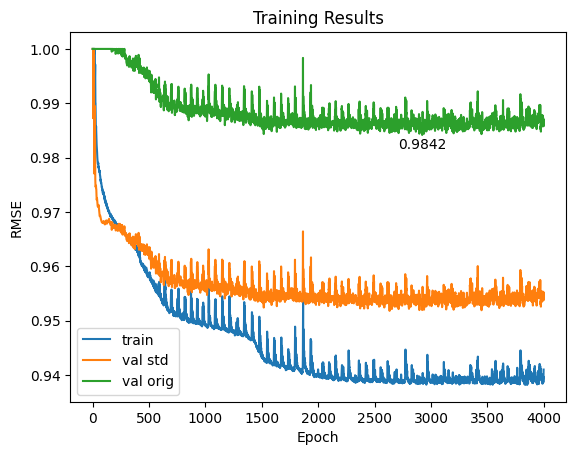

K=28, L=4, C=(3,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9790 - Val std: 0.9792 - Val orig: 1.0117
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9514 - Val std: 0.9568 - Val orig: 0.9893
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9478 - Val std: 0.9543 - Val orig: 0.9867
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9475 - Val std: 0.9548 - Val orig: 0.9871
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9470 - Val std: 0.9553 - Val orig: 0.9877
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9461 - Val std: 0.9549 - Val orig: 0.9873
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9448 - Val std: 0.9547 - Val orig: 0.9871
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9426 - Val std: 0.9543 - Val orig: 0.9868
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9407 - Val std: 0.9544 - Val orig: 0.9871
Best val loss: 0.9838 at epoch 3815


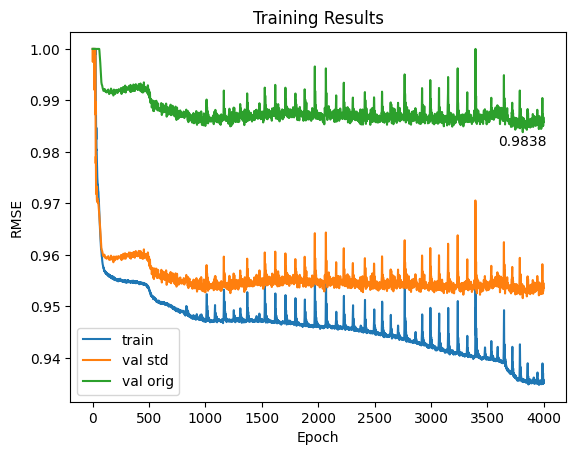

K=28, L=4, C=(2, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9658 - Val std: 0.9662 - Val orig: 0.9987
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9484 - Val std: 0.9564 - Val orig: 0.9887
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9467 - Val std: 0.9561 - Val orig: 0.9883
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9450 - Val std: 0.9559 - Val orig: 0.9880
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9433 - Val std: 0.9562 - Val orig: 0.9882
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9430 - Val std: 0.9563 - Val orig: 0.9884
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9432 - Val std: 0.9567 - Val orig: 0.9887
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9439 - Val std: 0.9570 - Val orig: 0.9890
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9506 - Val std: 0.9613 - Val orig: 0.9936
Best val loss: 0.9858 at epoch 1389


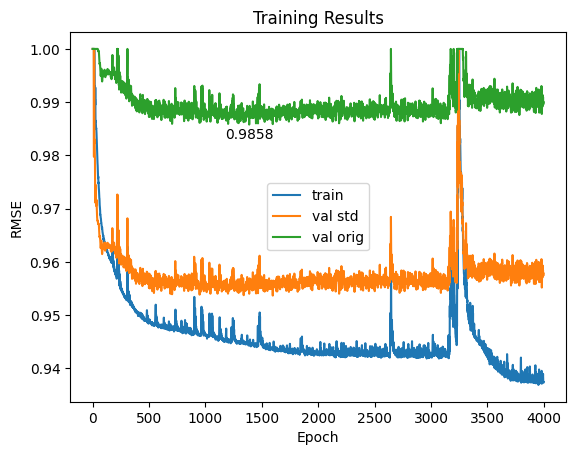

K=28, L=4, C=(2,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9675 - Val std: 0.9722 - Val orig: 1.0048
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9505 - Val std: 0.9600 - Val orig: 0.9924
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9438 - Val std: 0.9544 - Val orig: 0.9867
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9405 - Val std: 0.9542 - Val orig: 0.9863
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9394 - Val std: 0.9539 - Val orig: 0.9861
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9394 - Val std: 0.9540 - Val orig: 0.9862
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9391 - Val std: 0.9539 - Val orig: 0.9861
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9390 - Val std: 0.9538 - Val orig: 0.9860
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9389 - Val std: 0.9536 - Val orig: 0.9859
Best val loss: 0.9830 at epoch 2935


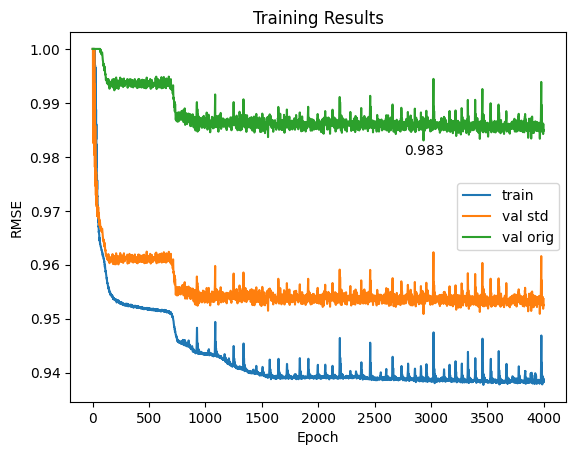

K=28, L=5, C=(6, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 1.0155 - Val std: 1.0026 - Val orig: 1.0353
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9600 - Val std: 0.9608 - Val orig: 0.9930
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9526 - Val std: 0.9580 - Val orig: 0.9903
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9476 - Val std: 0.9551 - Val orig: 0.9873
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9445 - Val std: 0.9542 - Val orig: 0.9863
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9406 - Val std: 0.9544 - Val orig: 0.9865
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9385 - Val std: 0.9544 - Val orig: 0.9864
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9366 - Val std: 0.9544 - Val orig: 0.9864
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9325 - Val std: 0.9543 - Val orig: 0.9863
Best val loss: 0.9844 at epoch 3935


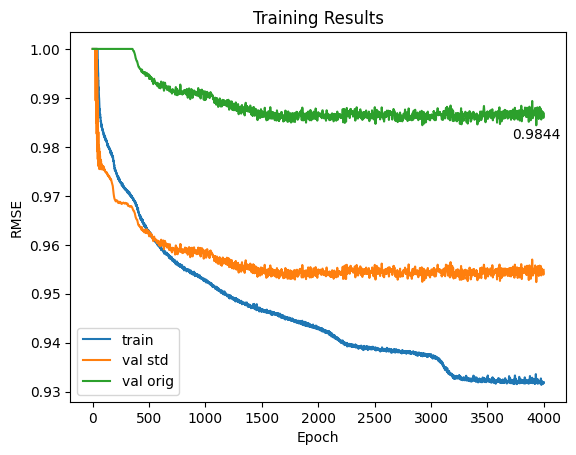

K=28, L=5, C=(6,)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9935 - Val std: 0.9945 - Val orig: 1.0271
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9428 - Val std: 0.9520 - Val orig: 0.9843
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9391 - Val std: 0.9518 - Val orig: 0.9839
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9373 - Val std: 0.9525 - Val orig: 0.9847
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9341 - Val std: 0.9524 - Val orig: 0.9846
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9292 - Val std: 0.9533 - Val orig: 0.9854
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9265 - Val std: 0.9539 - Val orig: 0.9860
Epoch 3200 - Avg loss in last 400 epochs: - Train: 0.9241 - Val std: 0.9544 - Val orig: 0.9868
Epoch 3600 - Avg loss in last 400 epochs: - Train: 0.9237 - Val std: 0.9552 - Val orig: 0.9878
Best val loss: 0.9824 at epoch 1818


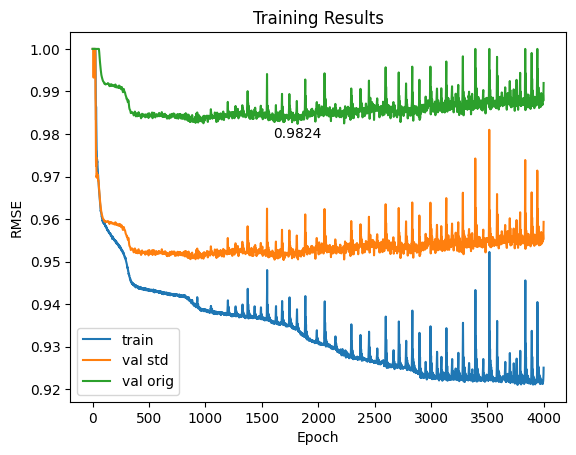

K=28, L=5, C=(5, 1)
Epoch 400 - Avg loss in last 400 epochs: - Train: 0.9799 - Val std: 0.9766 - Val orig: 1.0093
Epoch 800 - Avg loss in last 400 epochs: - Train: 0.9555 - Val std: 0.9592 - Val orig: 0.9915
Epoch 1200 - Avg loss in last 400 epochs: - Train: 0.9483 - Val std: 0.9547 - Val orig: 0.9870
Epoch 1600 - Avg loss in last 400 epochs: - Train: 0.9467 - Val std: 0.9544 - Val orig: 0.9867
Epoch 2000 - Avg loss in last 400 epochs: - Train: 0.9461 - Val std: 0.9546 - Val orig: 0.9869
Epoch 2400 - Avg loss in last 400 epochs: - Train: 0.9451 - Val std: 0.9543 - Val orig: 0.9867
Epoch 2800 - Avg loss in last 400 epochs: - Train: 0.9446 - Val std: 0.9547 - Val orig: 0.9870


KeyboardInterrupt: 

In [6]:
# Tuning LightGCNPlus
results = {
    "min_val_losses": [],
    "params": []
}
for K in ks:
    for L in layers:
        for C in projections:
            model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
            loss_fn = nn.MSELoss()
            print(f"K={K}, L={L}, C={C}")
            train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, verbosity=400)
            report_training_results(train_rmse, val_rmse_std, val_rmse_orig)
            
            results["min_val_losses"].append(min(val_rmse_orig))
            results["params"].append((K, L, C))

In [12]:
# Report top k best hyperparameter combos
TOP_K = 10
best_ids = np.argsort(results["min_val_losses"])[:TOP_K]

for i in best_ids:
    print(f"Best hyperparameters: {results['params'][i]}")
    print(f"Best val loss: {results['min_val_losses'][i]}")

Best hyperparameters: (28, 5, (6,))
Best val loss: 0.9823721051216125
Best hyperparameters: (28, 4, (2,))
Best val loss: 0.9830349087715149
Best hyperparameters: (28, 4, (6, 1))
Best val loss: 0.9835354685783386
Best hyperparameters: (28, 4, (3,))
Best val loss: 0.9838272929191589
Best hyperparameters: (28, 4, (4,))
Best val loss: 0.9839051961898804
Best hyperparameters: (28, 4, (5,))
Best val loss: 0.9839432835578918
Best hyperparameters: (28, 4, (3, 1))
Best val loss: 0.9841679930686951
Best hyperparameters: (28, 5, (6, 1))
Best val loss: 0.9844056367874146
Best hyperparameters: (28, 4, (4, 1))
Best val loss: 0.9851052165031433
Best hyperparameters: (28, 4, (6,))
Best val loss: 0.985187828540802


In [11]:
# save validation set to train ensemble

val_df = pd.DataFrame({
    "user": val_users.cpu().numpy(),
    "item": val_items.cpu().numpy(),
    "rating": orig_val_ratings.cpu().numpy()
})
val_df.to_csv("../data/model_state/val_df.csv", index=False)

## 3. Retrain model on best hyperparam combo

In [13]:
# Setup for final training
EPOCHS = 4000
K, L, C = (28, 5, (6, ))
DROPOUT = 0.4

model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

Epoch 1 - Avg loss in last 1 epochs: - Train: 1.1334 - Val std: 6.6901 - Val orig: 6.8385
Epoch 2 - Avg loss in last 1 epochs: - Train: 6.7470 - Val std: 1.1000 - Val orig: 1.1244
Epoch 3 - Avg loss in last 1 epochs: - Train: 1.1287 - Val std: 1.5510 - Val orig: 1.5922
Epoch 4 - Avg loss in last 1 epochs: - Train: 1.5593 - Val std: 2.1381 - Val orig: 2.1613
Epoch 5 - Avg loss in last 1 epochs: - Train: 2.1765 - Val std: 1.6483 - Val orig: 1.6845
Epoch 6 - Avg loss in last 1 epochs: - Train: 1.7216 - Val std: 4.2742 - Val orig: 4.3484
Epoch 7 - Avg loss in last 1 epochs: - Train: 4.3986 - Val std: 1.2082 - Val orig: 1.2482
Epoch 8 - Avg loss in last 1 epochs: - Train: 1.3084 - Val std: 2.9449 - Val orig: 3.0216
Epoch 9 - Avg loss in last 1 epochs: - Train: 2.9748 - Val std: 2.0525 - Val orig: 2.1152
Epoch 10 - Avg loss in last 1 epochs: - Train: 2.0725 - Val std: 1.1967 - Val orig: 1.2255
Epoch 11 - Avg loss in last 1 epochs: - Train: 1.2143 - Val std: 1.9450 - Val orig: 1.9641
Epoch 12

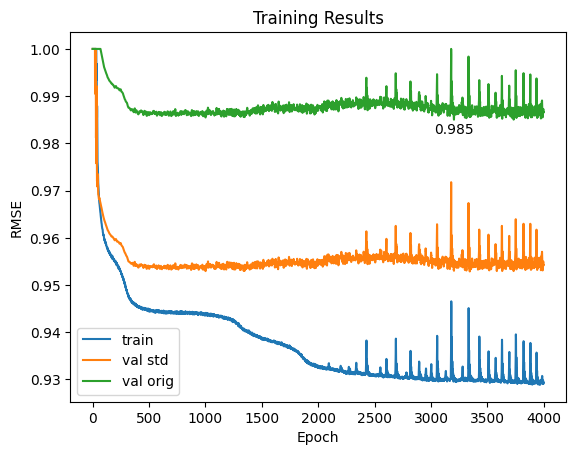

In [15]:
# Train and report
train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, verbosity=1)
report_training_results(train_rmse, val_rmse_std, val_rmse_orig)

## 4. Post-Process and generate submission

min: -2.404163
max: 1.7789776
mean: 0.019548155


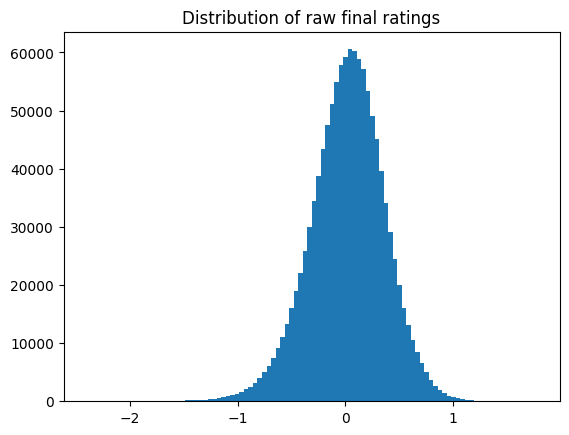

min: 0.16879694263536926
max: 5.644300448857044
mean: 3.876345880885169
count_over_5: 11251
count_under_1: 52

min: 1.0
max: 5.0
mean: 3.875247552096399


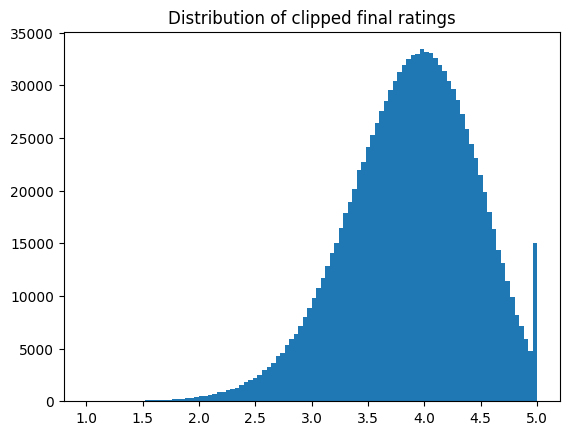

In [16]:
from postprocess import postprocess_report_submit
from models import LightGCNPlus
ID = str(K) + "_" + str(L) + "_" + str(C)
postprocess_report_submit(LightGCNPlus, ID)